In [237]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
import requests
import torch
import base64
import traceback
from ultralyticsplus import YOLO

from PIL import Image, ImageDraw
from io import BytesIO

device = "cuda:0" if torch.cuda.is_available() else "cpu"
extractor = AutoFeatureExtractor.from_pretrained("rizvandwiki/gender-classification")

model_gender = AutoModelForImageClassification.from_pretrained("rizvandwiki/gender-classification")
model_gender = model_gender.to(device)

safe_img_base64 = "/9j/4AAQSkZJRgABAQAAAQABAAD/4QAqRXhpZgAASUkqAAgAAAABADEBAgAHAAAAGgAAAAAAAABHb29nbGUAAP/bAIQAAwICCAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICggICAgJCQoICAsNCggNCAgJCAEDBAQGBQYKBgYKDQoLDQsKCg4ODQoKCg0OCg0KCAoKCgoLCg0NDQ0KCgoKCgoNCgoKCgoKCAgICggICAoICggI/8AAEQgBOwGmAwERAAIRAQMRAf/EAB0AAQADAAIDAQAAAAAAAAAAAAAGBwgEBQIDCQH/xABWEAACAgECBAMEBQYIBwwLAAABAgADBAURBgcSIRMxQQgiUWEJFDJxgSNCUmJykRUWM0OCobTBJDZ0dZKxsxc0NTdTVnOUotHS1RgZJkRjg4WTo8Lw/8QAHAEBAAIDAQEBAAAAAAAAAAAAAAUGAwQHAgEI/8QATBEAAgECAwQGBQkGAwcDBQEAAAECAxEEBSESMUFRBiJhcYGRE6GxwdEUIzJCUmJy4fAVM4KSotIHNFMWJDZzssLTVMPiNYOjs/El/9oADAMBAAIRAxEAPwDds/H50gQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQDg6jrtNP8pYq/In3vwUbsfwEl8DlOMxzthqUp9qVo+MnaK8WatbFUaP7ySXjr5LX1EV1DmrUu4rrZ/mSEH4dmP7wJ0LB/4eYqok8TVjT7EnUfjrFeTZA1c+pR0pxcu/qr3v1I6HJ5pZB+ytaD7ix/eW2/qluof4fZfBfOTqTf4oxXko3/qZFTz2u/oqK8G/a/ccB+YWWf53b7kr/wDBvJiPQvJ4r9zfvqVfdK3qNV5vi39f+mPwPD+P2X/yx/0K/wDwTJ/sdk/+gv56v955/a2L+3/TH4Hsr5h5Y/nQfkUr/uUH+uYp9C8nktKLj3VKvvk16j0s4xa+vf8Ahj8DssTmrcPt11v93Up/1sP6pA4j/DzBT1o1akO/ZmvK0X/UbtPPqy+nGL818fYd9p/NKhu1ivX8/tqPxGzf9mVDG/4fY6km8POFVcv3cvKV4/1krRz2jLSonH+perX1Eq0/VK7RvW6uP1T5fePMfiBOfYzL8Tgp7GJpypvtVr9z3PwbJ6lXp1lenJS7n7TlSPM4gCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAdJr/ABhTj9mPU/6C7Fvx9FH3/gDLXk/RrG5q9qlHZh9uV1H+HjJ9ysn9JojMXmNHDaSd5clv8eXj4Jle6vzByLj01/k1PYLXuXO/l73nv+yFnacr6E5fg0pVl6efOa6vhDdb8W13op+JzivW0h1F2b/P4WOx0Dk3n5PvMngqe/XeSrH+hsbN/wBoKD8Ze04U0oxVktEkrJdxEbEpO79ZYejezxjrsb7rLT8EArT7vz2P3hl+6eHVfAyqiuJMMDlhp9Q93FqO3rYDb+/xC3/dMe3J8TIoRXA42VxdpOOSptw0K+aoKyR8iKwSD8tt5IU8uxdVXjTk13Ne0j6mY4Sk7SqRT70/YcUc59JPu/Wk/Gq4L+81dP8AXNn9iY1K/o3/ADR9lzW/beBbt6Rfyy9tjn4Or6VlnpRsK5j+YRUWP3Iw6j+AmnVwWJoK9SEornZ289xu0sbhq7tTnGT5XV/LeeOpcpNPtHfGVD8ai1ZH4KQv71M01OSNx04vgQrW/Z0rO5x8hlP6NwDD/TQKQP6DTIqvMxOjyK71zlvn4R6zW3Sv87QSyj5krs6j5sqzzVp0sRB06sVOL3qSTXk9Dwtum9qLafNP4HnonM21NhaPFX49lcfiOzfiNz8ZznNegeExCc8G/Qy5ayg/B6x8HZcIE7hs7q09KvXXk/g/HzLE0fiCq8b1uD8VPZl+9fP8fI/EziuZ5Ni8tnsYmDiuElrF/hktPDSS4pFww2LpYhXpu/ZxXevfu5M7GQhuCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAevIyFRSzEKoG5JOwA+ZmajRqV5qnSi5Sbskldt9iR4nOME5SdkuLK34n5ks29ePuq+Rs/Ob9kfmj5/a/Zncsg6C06Nq+Y2nLeqe+K/G/rPsXV57aZTMdnUp3hh9F9ri+7l37+47DgvklkZO1mQTRUe/vDe59/gp+zv+k/f16WnVtqMFsxWi0SWiS5FcVNy1l+ZdnDHAeLiD8jUA3rY3vWH+me4B+C9K/KYXJvebMYKO4kE8Hsq/mPz1owmamkDIyBuGAO1VR+DsO7MPVF+YLKZaMtyKrikqlR7EO7V9y5dr8EyrZlntLCt06a259+i73z7F4tGfOKeY2ZmEm+9yp/mkJSoD4CsHY7fFupviTOg4XLsPhV83BX5vWXm/dZdhz3FZliMU/nJu3JaR8l77vtI1JIjBAEAm3B/N/OwyOm021+tNxLpt8FJPVX8uggfEHykJjMnw2JWsdmX2o2T8eD8Vfk0TmDzjE4V6S2o/Zldrw4rw8UzRXLrm3j6gOlfyV4G7UuQSR6tW3bxFHr2DD1UDYnneY5TWwTu+tD7SXqkuD9T4M6Ll2b0carLqz+y/bF8V61xROJBk6Q7ivlTh5e7NX4Vp/natlYn4sNul/mSOr5iZIzaMUqakUhxdyyy8BvFG71KdxfVuOn4da/aQ/PuvfbqPlPVSFLEQdOrFSi1ZppNNdzMFp0ntRdrcVodlwtzJDbJkdj5C3yU/tgfZP6w7fHbznFukHQaVO9fLVtR3une8l+Bv6S+63tcnK9lbcDnSlaGI0f2uH8XLv3c7E9Vt+48px5pp2ej3FrTvuP2fD6IAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIBxNV1VKUNlh2UfvJ9Ao9Sfh/3GSWX5dXzCvHD4eO1J+SXGUnwiufcldtJ69evChBzqOy9/JdpVmfqeRqNy1VIx3PuVL5D9Zz2HYebHYKPh33/AErkPR3D5PS061RrrTa1/DHlHs3t6yb0S55jcfUxcrbo8F73zfs4dt2cveUFOIFstC3ZHn1EbpWfhWD6j9Mjf4Be+9jlUbNeFNR1e8sKYjMIBR/PXm81ROFiOVs/94tQ90BH8kh8w582YEFew33LdN4yLKFU/wB4rq6+qnx+81y5J79+616NnucOn/u9B2f1muH3V282t27fe2eCZ0M52fkHwQBAPKuskgAEk+QA3J+4CfG0ldn1JvRHLzNEurAaym1FPkXrdQd/LYsAJihXpzdoSTfY0/YZp0KkFecWl2xa9px8XKZGV0ZkdSGVlJDKR5EEdwR8RPc4RmnGSuno09VYxwnKDUouzWqa0dzU/Jfmp9eq8G5h9aqHveQ8ZPSxQNh1DsHAHnsR2bZeW51lXySfpKa+bf8AS/svs5Pw4a9UyXNflcPR1H84v6l9pdvNePHSzJWSzn4ygjYjcHsQfIiAVBzG5IK4a7CUI/ctR5I/zr9Eb9Tsp9OnbY7EKnBmtOlxiVvwrxm+M3g3BvDBKlSD11EHY7A99gfND5enqDQuk3RKnmSeIw1oVvKM+yXKXKfhK6s4yuXZpLDv0dTWHrj3dnZ5cnamPkK6hlIZWG4I8iJ+da1GdCcqVWLjKLs01Zp8mX6E4zipRd09UeyYT2IAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgHpzMxa0Z3PSqjck//AN5nyA9TNrC4ariqsaFGO1KTsl2/Bb29ySbeiMdSpGnFzm7Jav8AX61KoyLb9TyVrqUnckIn5qJ6u58h8WP3Ab+6D+oshyOjk+GUFZzdnOXOXJfdjuS729Wzm2Nxk8ZUvw4Lkub7Xx8jQ/AnAVODV0oOqxgPFtI95z8B+ig9FH3nc7mTkpORjjBRRJp4MggER5pcaDBw7LQR4rfk6R8bGB2O3wQAufj07eokvleC+V4iNN/RXWl+FfHd49hEZrjVg8PKovpPqx/E+Phv8O0xvZYSSSSSSSSTuST3JJPckn1nY0klZHGW23dnjPp8IFzS5w42mJ735XIYb146nZiP0rDsfDT5kEt32B2O0NmOaUsFHXrSe6PvfJe3gnwmsuyurjZadWK3y9y5v2cWuOYeKOfuqZRP+ENQh8q8f8kFHw6x+VPz6nP3DynPcRnWLrP6eyuUer69/rOiYbJMJQX0Np85db1bvURRONs0N1DLyg36QyLQ37+veRqxddO6qSv+KXxJJ4Sg1Z04W/BH4H2H9kDlU+Do+HfmWtk5+XQmTZbbsXoS9FdMZGI6vyaFRYxLF7Ov3ivQq+q+PxFeKhUm5JcG/bz8b24HmhgMPQm504KLfFL2cvC1+JeeRjq6lXUMrDZlYBlIPmCDuCD8DNGMnF7UXZritDelFSWzJXT4PUyjzv4BTBylNPam9S6J39xlIDoCfNQSGHwDbem56tkePli6LVTWUXZvmuD7+D7r8Tk+eZfHCVk6ekZK6XJ8V3bmu+3AhOg63ZjXV31HZ6nDD57ean4qw3Uj1BIk3iKEa9OVKe5q35963rtIPD15UKkasN6d/wAu57n2G1uG9eTKoqyKz7lqBh8QfJlPzRgVPzBnFcTQlh6sqU96dvg+5rXuZ23DYiOIpRqw3NX+K709O9HZTWNkQCvOaPKtMxTdSAmUo8/IXAfmv6dXor/cD22K5YTtozDOntareUzwhxO+LYabgRX1FWVgd6nB2J28x3+0Px8x3pHSvo1HM6XyigrV4rT78V9V/e+y/wCF6O8ZHLMxeGl6Of0G/J812c14rXfbCsCNx3B7gj1E/N0ouLcZKzWjXbyZ0FO+qP2eT6IAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIBV/MbXzbaMevcqhAYD8+w+m3r0+QHxJ+An6B6C5IsPh/l1Vdeour92nz757/wACjzaKLnWMdSp6GO6O/tl+XtvyLt5YcArg0DqAORYAbW89vUVg/op67fabc/DbpE5bTIeENlEzmMyiAIBm72muIOvJpxge1NZdv27T5H7kVSP2zOkdGcPs0ZVn9Z2XdH82/I5r0nxG1WhRX1Vd98vyS8ymJcylnQcd8XJg4l2U/cVr7q/p2MemtP6TEAn0G59JpYzFRwtGVWXBeb3JeL9Ru4LCyxVaNGPF+S3t+C9ehg/iDX7cq6y+9y9trdTMf6gB6Ko2VVHYAAek43XrTrzdSo7tu7/XJbrcjs9ChChTVOmrJKy/XN72+Z10wGcQD7kezLzOo1fQ9Py6WDEY9VGQo2BqyqK0S+sj02cdSdh1VvW2wDieT0WhPh9M1+0txIluTTQh6jjK/ibeQe3oPTv8QqKT8N9vMGdJ6NYaVOjOrJW22rd0drXzb8jmnSbExqVoUou+wnfvls6eSXmU3LkUw0h7MnEPXj34xPemwWJ+xaO4HyDqSf25zjpNh9mrCsvrKz718U15HSejGI2qM6L+q7rufwafmXRKWXUQBAKj548vhZWc2pdrKx+WA/PrH5/7VY8z6p6+4BM9OXBmvVhxREOWfEfWpx3PdBvWfinqv9H0+R/VnEOnmRqhUWYUV1ZvZmuU+Ev40tfvK++Za8kxm3H0E961X4eXh7O4nc5EWoQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEA42p5fh1WP59CO+37Kk/3TfwGHWJxNKg9NupCH80lH3mCvU9HTlPlGT8k2QDkto4yNQVn97wlfIO/fdwVVSfmHcP96z9fOMadNQgrJJRSXBJWSXZZWOWwvOd3rx8TTE1zcEAQBAMfc6snr1TLPwdF/wBCqtP/ANZ2DJY7OCprsb85SfvOO53LaxtR9qXlGK9xCJNkGUJ7XWqlcbEpB2FtzuR8fCQAfgDbvt8dvhKX0nqNUqcOcm/Jf/IuvRemnVqT5RS83/8AEy1OdnRhAEAn3KLnrqmhXG7Tcp6C/a2ogWUXAbgeLS4KMRuel9g67npZdzALi4r+kc4myqTSt2LidSFGtxMcpcQRsSLLLLfDfbyeoVsvmCCAR8sfbk49nvXnyNLpax2ssV7kZ2JZmIsZgWY7knpYdz3M6zkVRzwcL8NqPk3b1NHJM+pqGNnbjsy80r+tMsiWArxcHsx5O2dcv6WKx/Fbav7iZUOk8b4aMuU164y+BcejErYmUedN+qUDTE5mdNEAQDxtqDAqwBBBBB7gg9iD8iIPhlK3BOJqJqU9q8joB+NbNsN/vrb+uaGeUI4nLa8Jq/zU5fxRi5RfhJJ+B4wc3SxMGvtJeDdn5plvz8knURAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQDi6tjF6rUHm9bqPvZSP75I5dXWHxdGtLdCrTm+6M4yfsNfEQdSlOC4xkvNNED5G6qKtQVW7eNW9Xf0bs43+819I+Zn6/nrG67zltJ2lbwNLTUN0QBAEAyBztxejVMsfFq3/06q2P9ZM6/kk9rBU32NeUpI49ncNnG1F2p+cYsg0nCCKC9rvSmbGxLgNxVdYjH4eKikfgTVtv8dvjKX0npt0qc+UmvNL+0u3ReolVqQ5xT8m/7jLk52dFEAQBAEA2n7OOlGrSaOobG1rbdj+izkKf6SKrD5ETrGQ03DBxvxcpeb080kzkufVFPGztwUY+KSv5NtFmywFeLh9mPF3zbn/RxmH4tZX/cplP6Tzth4R5zXqjL4lx6MQviZy5QfrlH4Gl5zQ6aIAgHjZYACSQAASSewAHckn4AQfDKmRnfW9SNijtZkdY/6NW3BP3Isj89xEcNltec3b5qcV+KScYrxk0ecHB1cTBL7Sfgnd+pFuz8lHUBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAKj410psbJFte6hmFtbD81wQxH3hveHyI+Bn6Y6G5usfgVSm/nKSUJc3G3Ul4rqv70W+KOd5thXQruS+jLrLv4rz17mjRvA3FqZuOly7Bvs2p+hYPtD7j9pT6qR8xLhKOy7GnGW0rnfzwexAEAzj7TnD/RkUZIHa6s1t+3UdwT8yjgD5JOj9GMRtUp0X9V7S7n8GvWc36T4fZqwrL6y2X3r4p+opWXQpJ0XHHCaZ2Ldi2eVqbK36Dj3q3H7LgH5jcepmnjMNHE0ZUpcV5Pg/Bm7g8TLDVo1Y8H5rivFGDeINAtxbrMe5SltTFWH+og+qsNmVvIgg+s41XozoTdOorNO367HvXYdnoV4V6aqU3dNXX65rc1zOumAziAIBKuWnAVmo5deOgITcNdZ6V1Ajqb9o/ZUerEem5Ell+Cli6ypx3b2+UeL7+C7SNzDGxwdF1Jb90VzlwXdxfYbvwMFKkSutQqVoqIo8lVAFUD5AACdjhBQioxVkkku5aI4zObnJylq2233vVs989ng0n7MvD/AEY12QR3us6FP/w6h5j73Zwf2RObdJsRtVo0VujG775fkl5nSujGH2aMqz+tKy7o/m35Fyyml0EAQCoueXMIVocKlvylg/LkfmVn+b/asHmPRP2xtnpx4mvVnbRET5Z8OdCm9x7zjZAfRPVv6R8vkP1pw3p5nar1VgKLvGD2ptcanCP8Cev3nZq8C2ZJg9iPp5rV6L8PPx9i7SczkpaRAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAOu1/RFyKmrbtv3VvVWHkR/qI9QSJN5PmtXK8VHE0tbaSXCUHvi/anwkk7O1jTxeGjiabpy8HyfB/rhcrrhXiW/Sso7glTstte/axPRlPluPNW+8HzYT9TYHG0Mxw8cRQd4vzT4xkuDXFeKummc2q0p4ao4TWq9a5rsNL6HrlWTUt1LBkYdj6g+qsPRh5EGZWraMzJpq6OfPh6EAi3MzgwZ2JZT28QflKSfS1Qenv6BgShPoGJ9BJXLMa8JXjU4bpfhe/y396IrM8EsZh5U+O+P4lu893czGl9DKxVgVZSVZSNiCDsQR6EHsROyRkpJSWqevgcYlFxbjJWa0feeuejyQTmdyfxdTUGz8leo2TIQAsB391x28RNzv0kgjvsy7tvDZhldLGrrdWS3SW/ufNdnk0TOXZpVwT6vWi98Xu71yfb5p2M0cUezrqeMzdNP1msHs9BDEj03qO1oPxAUgfE+ZoGIyLF0W7R21zjr6t/qfedBw2e4SsleWw+UtPXu9a7iKV8t9RLdIwMzq9R9Wu7ff7nYfMyOWAxLdvRT/kl8CSePwqV/Sw/nj8SecG+zJqGQwOQBiVeZZyr2kfBalbsf+kZNvn5GZwvR/E1Xep83Hts34Je+xC4vpDhqStS+cl2XS8W/cmad4E5fY2nU+FjptvsbLG2NlrD8522G+252UAKu52A3O/QcHgqWEhsUl3vi3zb925cEc9xmOq4ue3VfcuCXJL373xZJJvkednw3oFmVfVj1Dd7XCj1Cj85z+qi7sfkDNbE4iOHpSqz3JX+CXa3p3m1hsPLEVY0ob27fFvsS17kbW0DRK8amuiobJUgVfidvNj+sx3Yn1JM4riK8q9SVWe9u/5dyWi7Edsw9CNCnGlDclb8+9vV9rOfNc2BAK95oc1Ew1NVRD5TDsPMUgj7b+nV6qh8/M9tg2WEL6vcYZ1NnRbym+D+F3yrDfcSU6izFvO199yN/Ub/AGj+A9dqJ0s6TRy2n8mw7vWkv5Iv6z+8/qr+J6WUpPK8ueIl6Sp9BP8AmfLu5vwXZaqrt2HlPzi227vVl/Stoj9nw+iAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIB0vFHC6ZKbH3XX7D+o+R+Kn1H4y05Bn9fKK21DrU3bbhfRrmuUlwfg9CNx2BhioWeklufufZ+kQHh3ibK0q8jb3T/AClTE+Havoyn0P6LgbjyIPvLP0vgMfh8yoKvh5bUX5p8YyXBrl4ptNM55VpVMNNwmrP1Nc12fp8jQnBvH+PnJvU2zgbvU2wsX8Pzl/WXceW+x7TYlFxMsZqW4kk8HsQCleeXKA375mKm9wH5apR3tA/nEHrYo7FR3cbbe8NnumR5uqP+713aP1W+D5P7r58Hv0elJz3J3W/3igut9ZLiua+8uXFbtVrnJl27HsROjnONx+QfBAEAQBAPfhYL2utdas7uQqqoJZifQATxOcacXKbslq29DJCEqklCCu3oktTVfJzlYMCrxLQDlWgdZ7Hwl8xUpHb4FyOzEAdwoJ5VnGaPGT2Ifu1u7X9p+5cF2tnVsmypYOG3P95Lf2L7K974vsSLGlcLIeNlgAJJAAG5JOwAHmST2AEAp3mFzzC9VOEQzdw2Rtuq/wDRA/aP65HT8A24I2I0+LNadXhEr7hXgt8lvGvLeGT1EsT12kncnc99ifNvM+nxHPek3S6nlyeGwtpVtze+NPv5z5R4b5/ZlL5dlcsQ1Uq6Q9cu7s7fLmrSppCgKoAUDYADYAD0An55q1Z1ZupUblJtttu7be9tl9jFRSjFWS0POYj0IAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIBwNZ0Ou9Oixdx6EdmU/FT6f6j6gyYyvNsTllb02GlZ8U9YyXKS4r1rfFpmpicLTxEdior9vFdqf6XNMrLWOEsjDcW1MxVTutte4ZP2tu4+8e6flvtP0HkXS3CZolSn81V3bLekn9yXH8LtLkpJXKLjcrq4brR60ea4d69+7u3E74Q9oIjZMxOoeXjVgBvvevsD8yhX9ky5ypciNjW5lwaJxHRkr10WpYvr0nuvyZTsyn5MAZgaa3mwmnuOxnk9FacyOR1GcTdW31fIPmwXeuw/GxRt73669/iH2G1my3PKuEXo5rbhyvqvwvl2PwaKxmWR0sW/SQexPnbR/iXPtXimZ+4o5WZ2IT4tDsg/nagbKiPj1KPd+5wp+Uv+FzXDYldSaT5Pqvye/wuc/xWVYnDPrwbXNdZea3eNmROSxECAeSISdgNyewA8zPjdtWfUr6InfCPJTPyyD4Ror9bLwU7fqoR1vuPLYBf1hILF51hcOvpbcuUWn5vcvO/YT2DyTFYl/R2I85aeS3vyt2o0Py85U4+nKSn5W9hs17gBtv0UHfoX1IBJPqx2G3PMxzWtjXaXVit0Vu73zfs4JHRMuymjglePWk98nv7lyXt4tk0kKTZC+LubWJibr1+NaP5qog7H4O/wBlPmO7D9EzJGDZilUUSjuKuYmZqDeH3FZPu0Vb7H4dXq5Hnu3ujbcBZ9rVaOFpurWkoRW9yaS9fs3vcrmBbdWWzFXb4I7jhblsFIsyNmPmKh3Uftn84/qj3fm3lOK9IOnMqyeHy68Y7nU3Sa+4vqp/afW5KDVy3YHJVC08Rq/s8PHn3bu8noE5A227stYnwCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCARTXeXVNu7J+Sc+qj3Cfmnp/RI/GdEyjptjcFanX+fprTrO00uyfH+JS5JogMVk9Gt1odSXZu8V8LeJCMrhnMxG8ROsbeVtDN2+8rsyj7wB987FlvSnLswtGNTYl9mpaL8H9F/wyb5pFTxGW4jD6uN1zjr+a8USPQefOZVstoTIUfpjpf/AE02H4srH5y1OmnuNBVWt+pPdJ9oTEfbxa7aT67AWIP6SkMf/tzE6T4GZVlxJXg8ztPs+zlVD9smr/aBZ4cJLge1OL4njm6LpmQet68K1j5vtSzH+mPeP75uU8biaStCpKK5bTt5bjUqYLDVXedOEnz2Vfz3nAXllpAPV9Xx/wAW3X9xfp/qmz+18a1b0svV7bGqsowSd/RR9fsudlhVabi+9X9Sxz6spprJ+9uxP4madXE162lScpd7b9Ru0sNQo604Rj3JL1nF1Lm5p9XnkK5+FQazf8VBX97Ca6hJmw6kVxIXrftFoNxjY7Mf0riFH+ghYkf01mRUuZidbkiutd5j5+Yeg2N0t/M0Aqp+RC7s4+Ts0+VJ0qEXUqSUYre5NJLvb0Mac6j2Ypt8kvgezQ+Wdr7G0+Evw83P4eS/idx8JznNunmEw14YRemnz1jBeO+X8Ks/tk9hckq1NavUXm/Lh469hYmjcP1Y69NagfFj3Zvvb+4bAfATimaZzi8znt4mbfKK0jH8Mfe7yfFsuGGwlLDxtTVu3i+9+7dyR2MhDcEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQDrNS4You72VKT+kPdb/SXYn8TJ/A59mGB0w9aSX2W9qP8ALK6XgkaNbA0K304JvnufmtSMZ3Kis/ydrJ8mAcf1dJ/fvL7hP8RMTBWxNGM+2LdN+N9pX7reBCVcgpv93Nx70pfD3nR5PK3IH2WrcfeVP7iu39ctdD/EHLp/vIVIP8MZLzUr/wBJFzyKuvouL8WvavecBuXuZ/yW/wD8yv8AvcSXXTTJ2ruvb/7VX3QZqvKMX9j+qPxPz/c+zP8Akf8A8lX/AI56/wBs8m/1/wD8Vb+w+fsjF/Y/qh8Tzr5dZZ86wvzNlf8AcxMx1Om2URV1VcuxU6n/AHRS9Z6jk+Le+Nv4o+5s7LE5U3H7dlaD5dTn92yj/tSCxP8AiHgoL5mlUm+3ZgvO8n/SbtPIaz+nKK7rv4e0kGn8r6F7uXsPwJ6F/cvvf9qU7G9P8fW0oRhRXNLbl5y6v9BLUcjoQ1m3P1L1a+slGDpddQ2rRUH6oA3+8+Z/HeUDF4/E4yW3iKkqj+9Ju3cty7kkTlKhTpK1OKj3L2/mcmaBnEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAOHl6zTW9ddltaWXEiqt3VXtKjdhWpIZyo7kKDsJkjTnJOUU2lvaTaXe+HifHJLRnMmM+iAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgEe4l5h4GHbjUZeZjY12ZZ4WJVdclb5Fm6jopViC7dTouy7+86L5soO3RwlavGU6UJSUFeTSbUVrq2t25+Cb4MxyqRi0pNJvdrv7iQzUMhE+Oebel6YF/hHUMPCLjdFyciqp3HfuiOwdx2PdVM38LgMTiv3FOU7b9mLaXe1ovExVK0Kf05Jd7seXA/NbTNTDHT9Qw83pG7jGyKrmQeXvojFk/pAT5icDiMK7V6coX3bUXG/c3v8AAQqwqfQkn3O5Ki00TKR/gvmDg6lU12n5ePmVJY1L2Y1qXItqAFkLISAwDK23qrKRuGBO3icJWw0lCvCUG0naScXZ8df1dNcDHCpGavBp8NHcxfqvMDVNO5mUaeNSzMjT9SrDthX2s+PSluLewrpq7VV+FdSHR0RbCpKs1hZ2fosMJhsT0dlX9FGNSm7bSVpNqcVeT3u8ZWabtfVJWSUK6k4Y1Q2m0+F9Nz3LvXxPL2xePtU0ji7hu/F1PMGLn2UU3aebW+p9K5VVNw8Bdq28eu8EvYr2I69SuNq1T50ewuGxmV4mFWlHagpSU7da+xKUetv6rjuVk1o1vb+4ypOliKbjJ2dla+m9J6dtzd05gTogCAdbxJq9NFFtuRkV4tSoerItsSpKtxsHNlpCLsTuOo7bzNRpzqTUYRc3fck232WWvkeZNJXbt2mUfYwz9N0n67iXcY4OtX5mUtlCHMXddgwJrF2RY1l2QWBsFZYbouxbuZeukUcRi/R1YYKdCMY2b2H2b7RVoxtpfm924icE4U7xdVTbfP4vezYE5+TBlb26OF6cxdLV+KKeHWxsh7itmR4TZCv4YW5ES6qxrMY1t4Z2Kb2vuydibx0Zrzouq1hHidqKjpG+y1fRtpq0rq/HqqyZFY6Kls/ObFnffv7fD3mk+FuJ8bMoS/Eyacuhxst9Ftd1b7djs9RKE7+YHke2wlOr0alGbhVi4SXBpxa8HqSUZRkrxd12anbTAexAEAQDxstCgkkAAEkk7AAdyST2AA9Z9SvogfP3n3zj4E1PXtM1HI1zMW/SLKxth42TZiW+BkHIr/KjHY7C3fqtxy4sTYBhsrDquV5fnWFwVXD06Edmqn9KUVJXjsvTa5blK1nvW9Ffr1sLUqxm5u8eSdtHfl7OBurg3jTF1HGqzMK+vJxb16qrqjurAEqR32KsrAqyMAyMCpAIIHMsRh6uGqOlWi4yWjT/AFx3prRrVE7CcZxUou6Z3U1j2QDjL2gdD0+36vm6tp+NeNuqm3KqW1dwCC9fV1oCDuC4AIkrh8qxmJjt0aM5R5qDa8Hufga88RSg7Skk+9Eu4e4kx8ulMjFvpyaLBvXdRYl1TgHYlbKyyNsQQdj2IImhVo1KM3CrFxkt6aaa70zNGSkrxd12amIPZm5gapj8ea7oeTqWZqGGteTdWuZa1pqZbMeyk1g+5V01XtUyUrXW3Y9A6UC9KznCYapkuHxlOlGnO8U9lWurTTvxd3FO8m2uervB4WpNYqdJyclq9X3W9vA/fpLePtU0bI0PU9O1PMxx4l1VmGlrLiWtSa7Ve2pdhd4iu1Vi3eIvSE6Qnvl/nQ3C4bGwr4evSjLSLUmryV7qyb3Wsmtmzve99LMzqTpOE4Sa36X05/q5JvpMtf1HB0rT9S07Us3BenPSl6sa5qa7hfTbYrW9GzWGpqABW5aorY+6E7TT6GUqFfE1MPXpQqJ0205Ru1ZxVlfddS3rW6VmZczlOFOM4Sa1to7cHv8ALuNR8r+InzNM07Lt28XKwcTIs2Gw678eu19h6DqY7CUnG0o0cRUpR3RnOK7lJpewlKUnKEZPik/Uenm1oD5WmZ+PXmnTnuxbkXOU9Jxd0P5bq6k6Qg7swdCF3IZCAw9YCqqWJp1JQ9IlKL2Pta/R47+56709x8rR2oNJ7Oj15dpi7hbhXHsfhvEq5hY92RpOS7ZFaZgP1/xMkXJRUTlbWkVg4ircbwa2PSoG9TdFr16kViqsstko1IpJuH0LRs5Pq6a9fTZ1Wrv1lDQgm6cVXTcXrrv1vZa+Gt9PI3xl5aVqzuyoiKWd3IVVVRuzMxICqACSSQAJy2MXJpRV29LLXXkiebtqyudK9prh2+4Y9Ot6XZczdCoubQS7E7Baz19LsT2AQsT6byXnk2Ppw9JKhUS332JaLm9NPE11iaLdlON+9Et4941o03Cys/JJFGHRbkW9I3YpUpYqg3G7tt0qNxuxA3G80MLhp4mtChT+lKSiu9u2vYt77DLUmoRcnuSuYs4L9r3jjXUfL0HhvAbTxY1aWZl/vMVPcCyzOwFsI8mNVTKrbrvuJ0bE5Bk2XtUsbip+ksm1GPuUJ28XdrWxCwxmJrdalTVu1/mvYXz7PetcYZOTfbxHiafp2KlHRj42Gy22XXs6sbnsXKy+lK61ZAniJ1GzfpPSCKvm1PKqVOMcBOdSTldykrJRs+qlsx1bad7Pdv1sb+HliJNuslFW0S5897/TLV5gcxMPSsZszPuGPio9Vb3MrsqNdYtVZfoViql3UFyOld9yQO8g8JhKuLqKlQjtSabS01sm3a/Gy3b3wNupUjTjtSdl+kQrE9rPhl2VF13S+ptgN8ylRufIdTMFH4kSRlkOYxV3h6n8kn7DAsXRf14+aLTxcpXVXRldHUMjqQysrDcMrDcFSO4IJBEhJRcXZqzWnLU2k77j2zyfRAEAQBAEAQBAEAQBAEAQD59fSM/4x8G/5WP7dhTq/RD/ACGN/B/7dUr+Y/vqXf74lp/Sa6cf4svkpdfTbiZmK9ZpusqVvFsFLCxUYK4AfqUsCUZQVI3YNB9DJ/8A+iqbSalCad4p7ltaX3brdqevC21ma+ZvdqzXHwIr7LnsY6RqWmYeta2L9Z1HUqK8iy3NyL2WtWG1dSItg6+isKpe5rDuD0isbKN7O+kWKw2Jng8HahTpycUoRirvi27aXd3ZW7bvUxYXBU5wVSrecmr6t/rzKh9trkLj8HZGl8Q8Os+A/wBb8F8dbbHr8Tw2uVk8RmfwrUrtrvpZ2rZSoCqCwM/0bzSpnUKuBx9qi2NpOyTtdJ3tpdNpxkldO92zTx2HWFcatHq62t6/Lmj6LZOr/WNNa8DpF2CbgvqviUde34b7Tkap+jxGxvtO3lKxY77UL9l/UYz+iK/4H1T/ADkv9lpnROn3+bpf8v8A75ELlH7uX4vcjp+bv/Gtov8Ak1P9nzpsYD/hmv8Ail/1UjxW/wA9DuXskef0jP8AjHwb/lQ/t2FPnRD/ACGN/B/7dU+5j++pd/vifQWcoLAVhzz9pHSeHaqbNTyDWchmWiqutrbrejbxGVF8kr6l6nYqoLKNyWAM1lmT4rMpSjho32dW20kr7ld8XyWuj4I1a+Jp0EnN7ycY99WdiBlNopzMcEH8tjXirIr3B/m78e0K/wCpbW36LL2jWpUKtna8ZdkleL8VJXXamuaZnTU49jXat/rR8ufYv5AVcSZ2q4mrZufk6bouSHqwGybRXdfk2ZFXi2MH6l2rxdm8Lodi499QGV+2dIs1lllGjVwsIQqVY2c9lXUYqDstOc+N0rbno1V8Fh1XlKNRtxi91+Lv8OHmad9oL6Pfh27Sst8DCXT8zGxrrse+m27pL01tYK70ssdHrs6elnK+Iu/UG7ENS8q6WY+GJgq0/SQlJRaajubSvFpJpq97bnua4qTxGX0XTeytlpXW/wBZ7vo2ub2VqHDdn1x3vs0zKtxa7GJayzHSim+pGY7lmr8Rql33PQtY77Tz0wwFPDZgvRJRVSKm1uSk5Si3bk7J97Z9y2tKdHra2dvCyaKM9h3lNh8X5Gua5xAn8IX2XrRXTY7iugWozsyBWUgVoa6aNiBUqMVG/SUs3SXH1cmp4fB4F+jio7TaSu7NJXvzd5S+02r6b9HA0o4lzq1es72/XsXI1T7HvsqNwrRn0nPOauZkJaiio0pStasg2U2Wb22Bh4jDpBCVjY9O5o/SDPFm06c1T2NmLT12m22nyWi4LtfMlcHhPk6ave77jQkqZIEXu5o6aucumNnYo1B161wjfX9ZK9JftV1de/QC4G25QFgCATN1YLEOi8QqcvRp22tl7O+2/dv079N5i9LDa2Lq/K+vkSiaRlEApz2xdSsq4X1x6iQ/8H3JuvmEs2rt8vL8m79/SWHo9CM8yoKW70kX4rVetI08Y2qE7cmZr9i/ktpF/AuRfdh4uRkZdWqNkW2012XI1JuqpVLGUvV4aV12p0Fel3LjYtvLj0jzHFU85jCE5RjF0tlJtKz2XJtLR3bad96VnoiMwVCm8K20m3tX077Hc/RK6i7aBnVsSVq1a3oB/ND4mIzAfAdW7bfFmPqZr9PIJY6nJcaSv4TqfrwR7yl/NNfefsRsPjnXGxcLMyVG7Y+LkXqD3Baql7AD95Wc+w1JVa0Kb3SlGPm0iZqS2Yt8k36j52fR7+zZpXEOn6rqmtUHUMq7UbcbrutuDJ+QpyLbga7EPi3WZJJsO7Dwx09O7dXW+lmcYnLa9LDYOXo4qmpWSWvWlFR1T0Sju7db6WruX4anXhKdRbT2muPJO/e7kv8AopdQsrbiXTutmx8PMxXpVjv0tY2bTa23kC641O+wG/TNDpzCMlha9rSlCafcvRyS8HOXmZcqbXpIcE1/3L3I43JX/jV13/Jsj/Z4E95l/wANYf8AFH21T5Q/z0+5/wDaef0v3+8dF/yrL/2NU+dAP31f8EPbI+5x9GHe/Yib/Spf4r0f50xP7PlyM6D/AP1KX/Kn/wBVMzZr+4X4l7GaT5Cf8BaL/mnTv7HTKdmn+dr/APNq/wDXIk8P+6h+GPsRmP6V3jK7H0DFxqnZEzc9EyOkkddNNNtvhN+q1oqcj18MfOXToLh4VMdOpJXcKba7G2lfyuvEi82m40klxevdZv8AXcVh7XfsiaJpPB9GbiYoTOx/qHXliy0vkG/oS82hnNZDs/iKFRegqoXpXdTNZBn+MxeaypVZ3hL0lo2Vo2u420volbfrfW71NXGYOlTw6lFaq2vO+8k3tS8xMqzlppNzWubc+rSaMqzqPXavgtbYXbzJtfHVn/S3YHsSJp5JhKcekNaCStB1pRXBdZJW7lLTloZcVUk8HF89lPy/IjfNv2QtDo4Ao1SjFFWo16bpue2X4lpe23JGMchLFZzWa3FzhECjoITbybq3MBn+MqZ5LDTnem6lWns2Vko7ey1pe62Vd311v2Y62DpLCqaXW2Yu/fa/tNDcitOs4m4BxsbKuYW52m5OEcht3YPj3X4tNz7newg0Vu+53fv33beVPM5xyvO5VKS0hUjO27SUYzlFcvpNLlyJCgniMKlJ74tX7m0n6ijeTvC3MrhnEOl4OkaXqGHTba9Nt2RQdhYxdxUf4RwbehnLOBdT1gsfIbKLLmFfo9mlX5TWrVKc2kmlGXBWV+pNXS06sraeJo0YYyhHYjGMl3r4r1ouT2W/bIy9V1PL0LWtOXTdXxUezprLeFYKyniV9FjOyOFdbUIttS2sswZeleuvZ30epYTDwxuEqelpSaWtrq97O6tdXTT0TUrJp8N3C4yVSbpVI7Ml+v1vujTXEvDOPmUW4uXTXkY9y9FtNyB67F3B2ZWBB2IDA+YIBGxAMplGtUozVSlJxkndNOzT7/1oScoqS2ZK6KP4k9gfhPJqer+CKaCwIW3GsuptrJ8nRhYVJXzAsV0PqrDtLLR6U5nSkpemcuySjJPsensafJo0ZYChJW2bd10UR9HFxLlYWqcQ8MW3tk4ul33nFdu/hnHy3xbgnn0Jf7lvhg9KurkAF3JtHS+jSr4bDZjGOzKpGO123gpq/bHVX4prkjQy2UoTnQbuot28HZ+ZvmcsJ8QBAEAQBAEAQBAEAQBAEA+dH0n2RemtcKtiotuStljY9bkBLLxl4ZpRiWQBXs6VJLoACfeXzHXehSg8Ji1Udo2W01vUdipdrfql2PuZXM0uqlPZ38O+6sczn9pfMbX9MOmZPDunV1Xmqy5sfMxFtSym8uiobdXsTpKpWT7jfaI3B8seVTyDLsR8op4mbaultQm0042bdqSe9vitx6xCxlaGxKC8Guf4js+WmtczdL0/E06jhrS3pw6Eore3LxTayINgXKa0ilj69KKPkJgxtPo7i688RPFVE5ScmlCdrvlek9PE9UpY2nBQVONkrb1/cQnnxyT5h8VCk6lpunYtWD1WU4VWXSi5FjlQ5LLmZW9nQOkGy+lEXq6dmZuqSyvMsiylyWHqzm56OThJ7KV7b4x0vyjJt2votMFehi8Rbbilbhda+t+1Fr3cZczrqPqo4e0XEFivQbfrFLJRUUVFcKur3HsC/YVW7dI9w+Rglh+jsJ+keJqztaVtl3bu21rSXZxW/ebe3jWtnYiuG9af1FW8g+VnMThNMvE07RtOzqMi5bTZdl4xTrRfD66d9RwrQrqF3FtQPujsvvAzea47Ic3cKtevUpyjG1lCV7N3s+pNXT5PjxNXD0sXhrxhFNN33r1ar1lh8lfZ84m1DitOJ+JcbF084lJSjFx7arRY/gPRWFFWRldFaC2y5msvLmzpAXpJ6InMs2y7DZY8uy6Uqm07uUk1ZbSk73jG7dlFJRts3u779ihh606/pqyUbLcu63N9+/eS/wBsb2c9U1nWeGMzBqrsx8DK6s12urrNFYycW7xOl2VrQVqcdNQd9wPd2O80Oj2b4bBYTFUqzalOPVVm7vZnG11u1a32VuJmxmGnVqU5R3J669qf6sa3lCJc+dfte6EufzF4ZwsgdWMcfBc1t9hwubm22KQexFvgrUw9QAJ1vIKrw+QYqtT+ltVFfiupTS8tq67Su4yO3i6cXusvbL4H0UnJCxHyQ9kLivijHz+IrOGdMw9TW3Kq+tnLtrqFQF2ccfw+vOwurxA13Vt4m3Qu/RuOrvOf0MtqUMNHMasqVoPZ2U3fq09q9oT3Wjy3vfwqODnXjKboxUtdb98rcV2mgOONZ5oariX6e+iaVgVZlbUXZVWVj+IlVo6LAp/hXKK9SEqWWh3AJ6eltiKrhqfRvCVY11XqVHFqSi4Ss2tVf5uO58HJK+/QkJyxtSLg4RV9L3W7+Z+wjXIngrmFwvhW6bp/D+lZNRvsyDk2ZdLNfbZ4VZbvqmKQoqrUKDTWQFG/cnfczPE5FmtZYiviKkXsqOyoS0S2n/py1u3frPfoY6EMXh47EIRet73W/T7y4dhGeVXIPmHw/lZGo6Xp+Av8IWO+TpQysZ8asCxnrUrbl17LV4jLU1OZZYqEqzHcg7uOzTIsxpxoYmpPqJKNTYkpPRJvSL32V9qCV9UjFSw+Loyc4RWu+N1b2+VmbV9nLirijKXL/jLpmHprIafqf1S5LfGDCzx/ECZmYF6CKukl0Ldbe6enec4zehltJw/Z9WdW+1tbUWrbtm14w368HuWupNYadeV/TRUd1rPvvxZcsrxunzo9hrR0yuNuKsvN2fUMa/MFK2d2r8TOspuesHuvhIleOCNumu3pGwbadc6TVHSyfCUqOlOUYXtxtTi4p97bl2yjfgVzApSxNSUt6b9rT8t3cz6LmcjLGfO3mn7YPHXD+Ri4Go6dol12W7VYd6eIxzSjpX4nh06gng9bWJt4tOOCSdl9x+nreB6P5LmNOdehVqxUVeSdls3TdruDvZJ7pS7Xqr12rjMVRajOMXfRdvk/ciXcSaHzN17HvxMinQ9Dx2psovrsau8Z9WUhR03rOstX4KqRuDik+PuDaV3qj6NXo7l9SNWEq2IldSTScdhxd09fRX2n+P6OuzfrZpRxtZOLUYLdzvf+bd4b+PCC8A+xLx9peDk6bg65pFGFmeJ49ItyLN/FQVWGt7dJeylnrAUml6ydgd9wCJTFdJMjxVaOIrUKspxtZ2itzurpVUnZ/aT8jXp4LFU4uEZxSff/AG+w1Z7Hns3HhjSTg2XrkZF+Q+Vk2VhlqFjpXUK6urZjWiVL7zBSzFz0qCFFG6QZx+1cV6aMdmKioRT32Tbu7cW29FuVtXvJbB4b5PT2W7u936vgXTqenJdXZTYOqu1HrdfijqVYfipIlchNwkpR3pprvWqN1q6sz57cqeSfHnCGRm4eiYWn6rp2VeLUtyb6kVdh0LYazmYd1dpq6FtULchKDpJ2BPWMdmWS5zCFXGTnRqRjZqMW+1q+zJNXvZ9V66lepUMVhm400pRb4v8ANeO/sOh5H8p+YXDWTqluDoWn5Z1K2t7nuzMU1A1PkOvgD+EsW1VJyH38VSdgvlsd9rM8fkWaU6Ua2InD0aaVoTvqoLrfNyX1VufMx0KWLoSk4wTv2rt3armefBfJvmDp+s5fEyaPpuRqOoC+u3Fsy6OihbHpbqQLn1JsFqWpP8LuYKG6gSVafMTmGRYjCQy51qkacNlqShK7aUlreDfG76kVe1nbQ+wo4uFR1lFNu+l12dvZzZIOafI3jXi/P0+jXNPwdM0vCyLHa6i+l2spsZBYehM3Mta5qqwtY6akVnYsR+bqYHM8oyahUng6k6tWcUrOMlZpO2rhFWu7ve7LTt91aGJxMoqrFRinwa3eb18i/Pb55K6hruhLh6ZUt2TXnY+QKmtrp660S6t+l7WSsFfFDbM67hW23OwNW6LZlQy/G+lxD2YuEo3s3q3FrRXfC2i3tEhj6E61LZhq7p8ufPvLr5X8O2YemadiW9Pi4uDiY1nSd18SjHrqfpPqvUp2PqJXMbWjWxFSrHdKc5Lucm16mbtKLjCMXwSXqKp9tT2crOJdGOJjuleZj3pl4ptJFbuiWVvS7AMVWyuxtm6SA6177Dcic6OZvHK8X6Wom4Si4StvSbTTS7Gl4N21NXG4Z16eyt6d18DLXHHLjmNquhfwDmaTp31ehMZVyfreOMvIGIyeEAy59lJdgo6msppDAHchvO74bGZBhMb8tpVp7Tcns7EtlbSd9HBO2uiUpeRFTp4ypS9FKKsra3V3bx9yOi455McwNR4fwOHrtBw68XCenotTNwheVxqjXUbGOqPWeoW2dXRSDuq7BfXZw2Y5HhsdUx8cRJympXThO3Wd3ZejT0srXfF7zHUo4udJUnBWVuKvp4+4kvH3LDmLqWk4/DVmm6Xj6dVTh4z5lOVUDbVhrWKhcWzLrduqqux/Cw1ZmUbALup08LjchwuKlmEatSVRuctlwejle9rRS3NpXnZJ666mWpSxdSmqLjFR0V78Fa19fYiS8r25j6JptGl4nDuk3U4QFVNjZdJNqM1tltrE6vT7zWMG/k6/tn3e3bTxv7Ax2IliauJqxc9WtiWjtFJL5p6Jdr3bzLS+WUoKEYRsu1dv3iRf7rHNL/mvo3/WqP8AzyanyDo3/wCqq/yS/wDCZPS47/Tj5r+4pjh3lBzExtfu4nOi4ORqOUtiPTZmYYoqVq66VComo1HZKa1rT/CLTsCW6j3lirZhkNXAxy7084042aahO7d3J6um98m2+qtd1loaUaOLjVdbYTk+1d3Pl2l0jmvzR2P/ALMaPvuNh9ao8u+5/wCHPTt++Vz5D0bv/mqv8kv/AAm76XHf6cfNf3HF1DmbzUsRkThzSKWYFRauTis1ZPbrVbNasQsvmOut1+Kt5T3DBdGotN4mrJctmav2aUk/Jp9qPjq45/UivFf3E39h32V8rQKs3N1S1btW1SwPkdDeIKUDPZ0G3sLLbbLGstZfc3CBS3SWaN6S55TzCVOjhls0qatG6td2Svbgkkklv33teyz4HCyopynrKW/9c+ZqOUklBAEAQBAEAQBAEAQBAEAj/H+Dm2Yly6dfTjZuytj25FXjUdaurFLkGzeHaoatmQh0D9S7lQDt4WVGNWLxEXKHFRey7WavF81vs9Haz3mOopOL2HZ8L6rxMi4nsq8Tazr+natxRk6YuNpTpZj4um+MVseqwXIALawVR7VRrXstd2VAgRQd1vss8y7BYGphcujU2qiacqmzomrPc96TaSSSTd23ucQsJWq1Y1K7Vo7kr9/E21Obk2IAgHG1TFZ6rESw1O9bqlqgFq2ZSFsAPYlCQwB7Hae4SUZJtXSadua5eJ8aurFLeyfyS1TQ8TKp1XVn1Wy/KN1TM91gpTpAOz5DNZ1Wt77oPcUjsWLMxsee5lhsfVhPDUVRSjsvSKu+6OlluT3tb7WSNLCUJ0otTlta34+8vKVk3hAEAzD7Y3st5ms26fq2j5FeNrOkuGxzaemu9FsFyIX6XCvVaCydSmtxZYr7Bgy3Xo9ndLBRqYXFxcqNRWdt6dtlu2mjW+zurJx3WcXjMLKq41KbtKO72/rv1IVrfMHmbk474acP6diX2Iam1BM7GK1hh0m6qv69YVcfaXcW9J2PhnbaSNPCdHaU1VeInOKd9h05a8dlvYWnlfmYZVMbJbOwk+d15rX49xansYezF/FjTHx7rUvzsu36xmW19XhhgoSumosFZq6l6j1sqlnssOwBUCD6RZ1+1cSpxTjCK2Yp7993J24vknoku82sFhfk8LPVvV/DwL/lVJAQBAEAQDH/ALQHsV592r/xi4Z1FNL1Vh+XS3qWi9woU2dSV3AGxFVbabKLarWAc9J6i1/yrpHQhhfkGY0nVpcGrXS321a3Pc1JOK0V1a0PiMFJ1PTUZbMuPL9dlrMji6rzP8Pbx+HyvV4X1rrx9vE6ujbtsnX1dunwd9+3T6Tc2Ojm1fZr7r7Npbt/fa3G+7iY7422+Pfp+vUd3ye9iLUH1arX+K9TXVNQoKvjY9IP1al6yWqYs1dK9NLk2JRTRVWtvvlrNyDrZh0loRwrwOWUvRU3dSb+k09Gt7+ktHKUm3HSyPdHAzdT0teW01uXDs8uSS1NkTnpMiAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAejUMIWVvWxYLYjISpKsAwKkqw7qwB7Edwe89QlsyUlwafM+NXVjI//q09L/gkaT/COpeENSOpeL109XUaRj+H4fh+F/JD+V6evr3P2T4cvv8AtliflXyr0dO/o/RWs919q97338L2tpv1Ij9mQ9H6Paf0trhyt+v0jXWHjBEVASQiqoLEsxCgAFmPcnt3J7kyhSltNvnqS60PbPJ9EAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAIhx5zf0rS+j+EdRw8I2AmtcnIrqdwOxKIzB3UHsWVSAfWb+Fy/E4u/wAnpynbfsxbS72tEYalaFP6cku9nO4K5i4GpVm7T83Fza1PSz4t9dwRj3Cv4bN0MR36W2O3pMeJwlfCy2a8JQfKUXHyvv8AA9QqQqK8Gn3O5zuI+KMbDqa/LyKMWhPtXZFtdNS7+W9ljKoJ9AT3mKjQqVpbFKLnJ8Ipyfkj1KSirydl26EN4X9ozQM20UYmsabfcx6UqTLpNjny2rQuGsPyQNJGvlGNoR26tGpGPNwlZd7tp4mGOJpTdoyTfeiwcmosrKGKkqQGG26kjbqG+43HmNwRIlOzvvNgzV7D3L36hRqe3EacQrbnbF67jcmNZWG6+otdcRff1q1gB6T0IQX3LS5dJcX8onS/3Z4a0NzVnJO1raLqxs0uOruluIzA09hS6+3rzvb82VhxLyHvoGraPfxwatR1vNx8rAouvZLlqS24+F4ZyhZvlda17UeGrnGrAWwe4k1RzSFT0OLhgL06MJQm1FNXajrfZt1LN9a7W27tb3qyoNbVN1utJprXv7ePZy8DZnAugWYmFiYt2Q+Xbj41FFuVZ/KZFlVao9z7lj1WMpc7sx3PdmO5PO8TVjWrTqQioKUpSUVuim21Fdi3bl3LcTVOLjFRbvZJX59p3k1j2Qbm9zdx9Gx6Lrq7brMvMx9Pw8agJ4uTmZTFaaUNj11pv0szPY6qqqe5OymTy/ATxs5Qg1FRhKpKTvaMI/Sk7Jt8NEm234mCtWVJJvW7UUlxb3IiPGvEWTqvDWpXVrqWhZf1bNC+IFpzMe7DNh3R1Lg03GnZbqWBemwsjoSrDfw1GnhMwpQk6eIhtQ3daLUrb07axv8ARa0krSTV0YZylUoyavB2fY017nbeuG4rT6NLmnnarw/a2oZFuVbi6jdipfe7WXNSKMW9RZY5L2Mr3OAzknp6Rv7okz0ywNHCY5KhFQUqcZtJWW1tTi7JaK6itFxvzNbLKsqlLru9pNeFk/eaRwuYeBZmW6dXmYz59FYtuw1uQ5FVbdJDvUD1quzodyOwdCdutd6fLCVo0lXlCSpt2UrPZb10T3cH5PkySVSLlsJq64X1JDNQyFc8S+0doGHccfK1nTaL1PS9T5lAdG+Fi9ZNZ+T9Ml6OUY6vHbp0Kko81CVn3O2vga0sTSi7Skk+9E20DiPHy6lvxb6cml/sXY9qXVNt+jZWzIfwMjqtGpRlsVIuMlwknF+T1M8ZKSvF3XZqdfxvzBwdNpGRqGXj4dBdaxbkWpUjWMCVRSxHU5CseldzsrHyUkZcNhK2Kn6OhCU5WvaKbduenD3tHmdSNNXm0l2nbaVqtV9dd1Fld1NqLZVbU62V2Iw3V0dSVZWB3DKSCJrzhKnJwmnFp2aas0+KafE9ppq61OVPB9EAQDI/tnadiZeZpPVxdjaC+BebbsY5SpbYHapluFSXIwtrCMqG5ChFjbFdnFl96Ozq0aVa2DliFONlLYulbaTV2no73ey73S36WiMaoylH51Qs72v3a/8A95mneEuOMLPq8bBy8bMp328TGvrvQHz6S1bMA36p2I+EpdfDVsPLYrQlB8pRcX6yUhOM1eLT7nc7LVMhUrsZ7BSioxa1mVVrUA7uWf3VCj3t27DbvMME3JJK7utN9+zTmem7LXQyl7EuNhac+oYZ4txNeycvJFtVK5a2OgrD9diK99r2W3dQa7wiyL4Se83cy89JJVsSqdVYOWHjGNm9iy1tZNqKSUeF7PV6IisEow2o+kU23ff+fHj3GtpQyWEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAPmvwry/xOJOZOu06vWcvHwse9qaHdxX/gr4WLUpCMp6FFz2dAIVrD1EHdt+xV8XVyzo/h54V7Epyim0lfrKpNvXj1Ur/Z0RWoU418ZNVNUk/Vsr3+ZyeXHDNXDnM4aZpnVTp+oYzB8YO7qivgWZYX3yxITJo60LElEcqDsTv4xlaWZ9HflOI61SElaVkr/OKF9OcZWfNq59pxVDG7ENE1u8G/avImP0nvJnLyasHW6/FzMLTCFztM63WvwWtDtlJ4ezqXH5C+xSXSvwnXpFdhkf0LzGlSlUwcrQnU+hUsm9q1lB300+lFbnLaTu2kZs0oyklUWqW9dnP3PstyOHxf7LvCGt8K3azouMMGynAvy6barri9V2LU1tuLlpZbYpIZDW7kdY7WI5UjryYfO81wOZxwmMl6ROpGDTjGzjJpKcGkuDulu4NX3fJ4XD1aDqU1bRve96W5/rtRbP0dnNHL1Xhmt82x7rsPJvwVusJNltVVdNlTOx7uyLcKus+8wrBJLdRMD0uwVLCZi1RVlKMalluTbknZcm43t26aaG3l1WVSjeWtm17PjbwKe+iCP+Aa1/leL/sbJYen/wC/ofgn/wBSNPJ/oS717Dx+lr4OoTF0nVa1FebXmHE8ZPdsapqrMhN2GxPgWU71n8w2vtt1GOgeInKrWw0tYOG3Z6q91F6feUteeyuQzeC2Y1Fvvb1N+q3rN4cK5r24uNZZ2ssx6XsHl771qzdvT3iZzCvFRqSjHcpSS7ruxPRd4pvkinfa29qVOFcTEyWw2zTlZXgeGLxQERa2sezrNVvUwAAVOkAk7ll22NgyHJHm1WdNT2NmO1fZ2ru6SVrrzv4M0sXivk8VK17u2+x3nPrkknEmFiY7Zl2FVXk0ZwsorqOT11oxpNNtgY41iM/V4tYLbAr5M01srzJ5ZWnUUFNuMqdm3s2bW1dL6Sdtz048DJiKCrxSvbVPTf2W5HszuBH0/Q9Ups1DP1Jmw82zx9RsptuXfEZPDQ00UKKx0dQDKzdTOSx37fI4pYnGUpxpwpdeCtBNL6ad3tN6624KyWh9dPYpyTk5aPfbl2JGdvokf8X8/wDzzd/YsCW3p7/nqf8AyY//ALKpG5R+6f4n7IkZ5Pf8a2uf5Jd/sNPm7mH/AAzQ/HH/AKqpjo/56fc/ZE6L6QDSMleLdCrw9QzcKzV6qMK16si7pqF2V9TZ6qxYoQNVb79aFFcr1dmd2Oz0VqU3leIlWpwmqTlUScY62ht2btzWjd2r23JIx5hF+ngoya2rLe+dveaQ4d+jw4ToxxQ+m/WmK7WZGRkZByLDt3fqrtrWtj5/kUrA+Ep9bpbmlSptqrscoxjHZXZZp3/ibJKOXUErbN+1t3/XcZt5J6JbwlzB/gDDvts0rU6y/g2N1FQ2LbkUsw7L41FtTUi3YM1LHfu2wuOZVI5xkXy6rFKrTdrpW+vGMkuySe1bhNabiNoReGxfoovqv4NrxVrdxr72xeBMbUOGtYryEVvq+BlZtLMBvVkYdFl9ViN5qd06GK7bo7qdwzA0Do9iqmHzCjKm7bVSEH2xlJRafnfvSe9EvjIKdGSfBN+KV1+uRWf0YWrW28KUrYSVozcymnfvtV1LbsPkLLbNvhJnppTjDM5OPGEG++zXsSNbK23QV+bRrF3ABJIAA3JPYADzJPwlFWpLFS8pPam0bXMzLwtMvtyLMNeu20Y9q4zL1+HvXeV6G3b7O5U2AMydaqzCdx+SYvAUoVsRFRUtEtpbV7X1jv3b+TspWbSNSjiqdaTjB3t2aef67DLH0rWRfhjQ9RxMrLxslLsikGnItrQBFS1LAiuFW1W6h4igMykKxYIgW79BlCt6ehVhGUXGL1im+Kau1ua4PRPVWu7xWbNx2JxbTu1vfeXDy7+jx4bx8dfruK2q5lq9eTmZl15sttcdVjKiWqlYLEkHZrPLqscjqlfxfS3MKlT5mfooLSMYxjZJbldq708OUVuNynl1GK6y2nxbb/X63maeNOAhwPxtov8AA9tqafrFmPVdhtY1gFV2UMa6kliWtROtL6GsLOtg26j07tcsPinn2T1/laTqUlJqVktVDajLTc3Zxklo1w10jJ0/kmJj6PdK2njZr3rtLD+kv4mycjL4e4eS5sfF1TKX606nYWdWTRj1BvIMlJse0oSVLeGxG6KZE9DaNOnSxOPcdqVOL2ezqyk7dsrJX32ulvZs5nJylCinZSevmkvL4Ey46+jd0x8zRsrSLRpI02ytsnoSy63LFNlVtTixrl8PIUpYDaVbq8RSR+SVWjsL0wxEaVenil6b0iajdqKjdSTVrax1WmlrP7V1mnlsHKMqfVtv433W8e3t7DYU5+TAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAdbxPxFVh42Rl3t00YtFuRc22/TVRW1ljbeuyKTtM1GjKtUjShrKUlFd7aS9bPMpKKcnuSbPlbyG4l4pzde1jinhvRK8mvOfJxmXNuqSmtbbce8qrvl4PiXIKaurw2ZVDkEd1M7hmlHLaGCo5bmFdxcFGXUi220pxvZRnaL2nvs3YqtCVedWVejC97rV9z5rXQmuDyM5gV65/Gx9M0zJ1NjYi4T5dIShWxvqqlFXMrqCLQTWg+u2Pv1MwYnqMbLM8jlgv2WqtSNLR7Sg7t7W3r1W7uWr6iW5K24zKhi1V9Pspy5XWmlufLt7y18zmZzPsR67OFdEeuxWR0fJx2R0YFWVlOuEMrAkEEbEHaQccF0ci1KOLqpp3TUZKz4NfMm26uNejpx81/cZw4Z9lvmFj42p6diaemBp+rtvk465+nvRWu5Ph0k5uRfWrIRS5Bd7alVXZ9t5b62d5FUqUsRVqOpUpLqy9HUTb5y6kU2n1luSk24pEbHC4uKlCMbKW9Xjbw1b7O7eW5yO4b5i6HpaaThaBpVaJa5GVkZWPZYTe1jWX2eHquxKfk0UCj7KqCj7GQOZ1shx+JeKrYio20urGEktEkoq9Pjq31t7eqNyhHF0YejjCPe2uPH6Xu8Do/Z15N8wOE7MrGwdI07Nxsu6hrrrMvHZAKupTZQDnYV46kc7i2kk9K7KvvBtnN8wyPN4wqVq06coxlZKEr62dpdSa3rhLi9Xwx4aji8M2oxTTa4r1ar2Et1vkTxhxdn6cOKMTB0rStPtNz0YttdjZRJXqQCvLzT12Kgq63sqWpGsYK7HZtCnmmVZNQqfs2c6tWa2U5JrZ32esYaK97JNtpJtLVZnQxGJlH06UYrXR7/W/yRvoCcsJ8zR7e/s4ZfEekU1YBQ5mHkjJqqscVrehreqyoO2yo/vK6s5C+4VJHUGFy6LZxSyzFOVe+xKOy2lezumnZb1o07a634WIzH4aVemlDencrbQ+YvNOimqn+Lek2+FWlfiPlYwezoUKHfo1tU6mA3bpVV3J2VR2ExUwfRqc3P5VVV23ZQlZX1sr0t3e33s1o1Mckl6OPmv7jh8acYc0c7EycNuHdKoXKpsx3uqysXxa0uQ1u1fiazYgfpY7E1vt57EgTJhsP0boVY1ViaknGSkk4Ts2ndXtSTtftXefJzx04uOxFXVt6/uLw9ib2fLuG9EXDymRsu/ItzMkVnqrrssSqpalfYdfRVTX1MB09ZfbqGzGtdJM2hmeMdammoKKhG+jaTk7tcLuT8LX10N7BYd0KWzLe3d+r4GL9a17XMfmPrlnD+Fj5+f4bL4GU611eAcfC8R+p8rEHUpCADxd+590+nRadLB1Oj9COOqSp0774pt7W1UstIy0evDxIWUqscZN0km+3laPavadvzk5X8wtZ1XTNVv4fwku0m2uzGSnNwlqs8HJXJTxls1WxyGZQCEes9JI7HvNfLsbkWCwtXDQxE2qqaleE7q8XF7NqaW58U9T3WpYurUjUcFeO7Vc769YuP/dY5pf82NG/61R/55K/8g6N/wDqqv8AJL/wm56XHf6cfNf3FQYfIrmDTrg4qs0zTc7U38VRivl0ivFVqPqy9KDMorCrQzJWEyrj3Zn3Y9Rn5ZnkU8F+zI1alOkrdZQleXW2nrst3ctXeEeCjpoaaoYtVfTuKcuV1ppbmuHa+0sXmgnMnW8W3SbNI0rT8XNqqqyctcmnqRHRDkV+7qOW4rL9dbdGNYxTcKTv1GIwX+z+BqLExrVKkoNuMdl6tN7L+hFXtZ6ySvv5GzV+WVYum4xinvd148X7NxqvkHyfq0HSMPS6W8QY1Z8S3bpN19jtbdbtudg1jt0qSelOldz07yjZrmEswxU8TNW2nouUUkorwSV+bu+JK4eiqNNQXD28T0e0pmvXw7rtlZIdNI1FlI81IxLfeHzX7Q+6e8njGWPw8ZbnWpf9cdPE+YltUZtfZl7GZ7+iq4Vqp4csyVA8bMz7za/bq6aFSqqsnz6U2dwD5G1j6y2dOK8p5gqb3Rpxt3u7b8dF/CiPyqCVG/Nv1afrvIR9L2/+BaIv5zZeUQPU7U1A7fiwH4iSXQD99Xf3Ie1/AwZx9GHe/YiX1c1OaQAH8WNH7AD/AH1j+n/1yR7wPRt6/Kqv8kv/AAmX0uO/04+a/uKg445GcwdS1fD4jzNL063LwLKDi6b9boWmsUO11Z6Rm9JUXnxGLZviM+w26FCiwYbM8iw2FngKVWahNS2p7Em3dKL+pv2dP3dku3U1J0MXOoq0oq6tZXXDXnz7Tnc9uTvH3FZw0z9F0vT2wWe3HzKcytLFLopsq3r1HNbZrK6ypFIKuiHrUdZOLK8wyPKFN0K9SptpJxcG1o3Z6whuTf1tzejdj1Xo4rE2U4RjbVO/5v2FlcC8cc0qPAx8rRNMy60atLMu7JxEuesEB7HNGqIvV07nqXF6t+/Q57GGxWG6N1NqdOvUg2m1FRm1fgltU3pfnPxRs06mOVlKCfbde6XuNtzm5NiAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIBT/ALXTZZ4c1WnBwr8/IysWzEWjHAawLkqaXt6N+txUjluitXdjt2A6mWwZB6JY+jKtNU4xmp3lu6vWSvuV2rXdl23snp4va9DJRTbatp26EX9gjldmaRw3i42fU1GS92RkPQ+3iVLbZ+TWwDfpcoquV816uk7MGA3elONpYzMJ1KL2opRjfg7LVrsvpfja601MWApSpUUpaPVmiJUiREAQBAEAQBAEAQBAK0524XEJrqs4fv05bkLi7H1Kq1qblbp6HS2giyu2oq2yneuwWHfpKLvM5bLA7TjjozcXa0qbV09bpqWjT571bS9zWrqrZOk1fk/y5FN+yl7Kmpafquo8Q69lY+TquerVhMXqNVSWOj2MWauodR8KqtEROmutSOty+y2HPc8w+Jw1LA4KEo0oNPrWu2k0tzemrbbd3J7lbXSwmEnCcqtVpyfL9fpGr5RSWEAQCmvar5P6lremLiaXqTaZeuVVc1qvbWt1SLYrUu9BFqjqdLRt1AtUoI7hlsOR5hh8DiHVxNL0sdlxtZOzbXWSlpuTXdJ25PTxdGdWGzCWy73/AC08/As7g/SLcfExce+9sq6jGopuyXGz5FtdSpZe43OzWupsI3Pdj3MhsRUjUqznCOwnKTUVuim21FdiWngbME4xSbu7JX59vicvWtHryKbse5Q9V9VlNqHyeu1CjqfkysR+Mx06kqc1ODs01JPtTun5n2SUk0+Ohhfl3yh414NfKw9FxcPXtIuva+lLsivGyKSwC7nxbscK7KqLYqePWxUOorLOJ03F5hlGdKFXFzlh6yiou0XKL48FLRNu19lq9neyZB06OJwrcaaU43vvs/Xb3+B7f/R04o4p1rT9R4ooxNN07THFlOnUXJe9pDpYy/krb1/LtXWt1j2qfDRVSsHdh5/a+W5ThKlDLZSq1Kis5uLilo1fVL6Kb2Uk+s23LgPk1fEVIzrpRiuCd/jv467tyN3zmBPCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAf/2Q=="
safe_img_bytes = BytesIO(base64.b64decode(safe_img_base64))
safe_img = Image.open(safe_img_bytes)


In [247]:
# load model
model_yolo = YOLO('kadirnar/yolov8n-v8.0')

image_size = 640
model_yolo.conf = conf_threshold
model_yolo.iou = iou_threshold

def yolov8(img):
    results = model_yolo.predict(img, imgsz=image_size)
    object_prediction_list = []
#     img1 = ImageDraw.Draw(img)  
    for image_results in results:
        for box in image_results.boxes:
            x1, y1, x2, y2 = (
                int(box.xyxy[0][0]),
                int(box.xyxy[0][1]),
                int(box.xyxy[0][2]),
                int(box.xyxy[0][3]),
            )
            bbox = [x1, y1, x2, y2]
            score = float(box.conf)
#             category_name = model_yolo.model_yolo.names[int(pred[5])]
#             category_id = pred[5]
#             img1.rectangle([(x1,y1), (x2,y2)], outline ="red")
            object_prediction_list.append([bbox, score])

#     return img
    return object_prediction_list

# response = requests.get('https://i.ytimg.com/vi/_Z2VZ_WpCvc/hqdefault.jpg?sqp=-oaymwEbCKgBEF5IVfKriqkDDggBFQAAiEIYAXABwAEG&rs=AOn4CLCXi7Lk6BjYQzi-25Fki7F_IAajhQ')
# img_bytes = BytesIO(response.content)
# img = Image.open(img_bytes)

# yolov8(img)

Ultralytics YOLOv8.0.8  Python-3.9.13 torch-1.13.1 CUDA:0 (NVIDIA GeForce GTX 1050, 4096MiB)
Fusing layers... 
YOLOv8n summary: 168 layers, 3151904 parameters, 0 gradients


[[[115, 0, 148, 39], 0.37744140625], [[0, 0, 160, 92], 0.310791015625], [[23, 1, 61, 56], 0.27783203125], [[146, 1, 168, 50], 0.269775390625]]


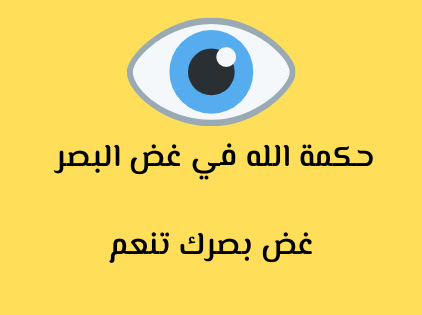

In [264]:
def main(url):
    try:
        if url.startswith('.'):
            img = Image.open(url)
        else:
            response = requests.get(url)
            img_bytes = BytesIO(response.content)
            img = Image.open(img_bytes)

        if ".svg" in url:
            return response.content
        
        objects = yolov8(img)
        print(objects)
        for obj in objects:
            left, top, right, bottom = obj[0] # bbox
            crop = img.crop((left, top, right, bottom))
            inputs = extractor(crop, return_tensors="pt").to(device)

            with torch.no_grad():
                logits = model_gender(**inputs).logits
                logits = logits.softmax(-1)

            predicted_label = logits.argmax(-1).item()
            percentage = logits[0][predicted_label]
            label = model_gender.config.id2label[predicted_label]
            
            if label == "female" and percentage > 0.79:
                return safe_img
        return img
    except Exception as e:
        print(traceback.format_exc())
        return img

# main("./bad3.png")
main("https://i.ytimg.com/vi/_Z2VZ_WpCvc/hqdefault.jpg?sqp=-oaymwEbCKgBEF5IVfKriqkDDggBFQAAiEIYAXABwAEG&rs=AOn4CLCXi7Lk6BjYQzi-25Fki7F_IAajhQ")

In [266]:
!pip install --upgrade ultralyticsplus

  Using cached ultralyticsplus-0.0.14-py3-none-any.whl (11 kB)
  Using cached ultralytics-8.0.8-py3-none-any.whl (256 kB)
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.0.10
    Uninstalling ultralytics-8.0.10:
      Successfully uninstalled ultralytics-8.0.10
  Attempting uninstall: ultralyticsplus
    Found existing installation: ultralyticsplus 0.0.3
    Uninstalling ultralyticsplus-0.0.3:
      Successfully uninstalled ultralyticsplus-0.0.3
